In [1]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, applications, optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import Sequence
from keras import utils
from keras import preprocessing
from tensorflow.keras import layers, models, optimizers, applications
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV3Large
from keras import regularizers

In [2]:
# Constants
FRAMES_DIR = r"D:\bangkit\Capstone Final\images\theframes"
BATCH_SIZE = 40
IMAGE_SIZE = (224, 224)
EPOCHS = 12
COLUMN_NAMES = [
    'dish_id', 'total_calories', 'total_mass', 'total_fat', 'total_carb', 'total_protein', 'ingredients'
]

# File paths for dish IDs
TRAIN_DISH_FILE = "training_dishes_nodeprecated_FINAL.txt"
VAL_DISH_FILE = "val_dishes_nodeprecated_FINAL.txt"
TEST_DISH_FILE = "test_dishes_nodeprecated_FINAL.txt"

# Load dish data CSV
dish_data = pd.read_csv(
    r"D:\bangkit\Capstone Final\metadata\dishwithingredient_FINAL.csv",
    names=COLUMN_NAMES,
    header=None  # No header row in the CSV
)

# Helper function to read dish IDs from a file
def read_dish_ids_from_file(file_path):
    with open(file_path, 'r') as file:
        return set(line.strip() for line in file.readlines())

# Load dish IDs from files
train_dishes = read_dish_ids_from_file(TRAIN_DISH_FILE)
val_dishes = read_dish_ids_from_file(VAL_DISH_FILE)
test_dishes = read_dish_ids_from_file(TEST_DISH_FILE)

# Filter valid dishes based on the number of frames available
def get_dish_with_frames(dish_ids, num_frames=3):
    dish_instances = []
    for dish_id in dish_ids:
        frames_path = os.path.join(FRAMES_DIR, dish_id, "frames_sampled30")
        if os.path.isdir(frames_path):
            frame_files = [f for f in os.listdir(frames_path) if f.endswith('.jpeg')]
            if len(frame_files) >= num_frames:
                dish_instances.append((dish_id, random.sample(frame_files, num_frames)))
    return dish_instances

train_instances = get_dish_with_frames(train_dishes, num_frames=10) #bisaaaa
val_instances = get_dish_with_frames(val_dishes, num_frames=5)
test_instances = get_dish_with_frames(test_dishes, num_frames=5)

In [3]:
# Custom data generator class
class DishDataGenerator(Sequence):
    def __init__(self, instances, batch_size, image_size, dish_data, shuffle=True):
        self.instances = instances
        self.batch_size = batch_size
        self.image_size = image_size
        self.dish_data = dish_data
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.instances))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.floor(len(self.instances) / self.batch_size))
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_instances = [self.instances[k] for k in batch_indexes]
        
        X = np.zeros((self.batch_size, *self.image_size, 3))  # Image data
        y = {
            "mass_output": np.zeros((self.batch_size, 1)),  # Mass output
            "fat_output": np.zeros((self.batch_size, 1)),   # Fat output
            "carb_output": np.zeros((self.batch_size, 1)),  # Carb output
            "protein_output": np.zeros((self.batch_size, 1))  # Protein output
        }
        
        for i, (dish_id, frame_files) in enumerate(batch_instances):
            for frame_file in frame_files:
                frame_path = os.path.join(FRAMES_DIR, dish_id, "frames_sampled30", frame_file)
                img = image.load_img(frame_path, target_size=self.image_size)
                img_array = image.img_to_array(img) / 255.0  # Normalize image
                X[i] = img_array

            # Extract the nutritional values from the dish data
            dish_info = self.dish_data[self.dish_data['dish_id'] == dish_id].iloc[0]
            y["mass_output"][i] = dish_info['total_mass']
            y["fat_output"][i] = dish_info['total_fat']
            y["carb_output"][i] = dish_info['total_carb']
            y["protein_output"][i] = dish_info['total_protein']

        return X, y

In [4]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Model

# Initialize data generators for training, validation, and test
train_generator = DishDataGenerator(train_instances, BATCH_SIZE, IMAGE_SIZE, dish_data)
val_generator = DishDataGenerator(val_instances, BATCH_SIZE, IMAGE_SIZE, dish_data, shuffle=False)
test_generator = DishDataGenerator(test_instances, BATCH_SIZE, IMAGE_SIZE, dish_data, shuffle=False)

# Model definition (based on ResNet50 for feature extraction and custom dense layers for output)
frame_input = layers.Input(shape=(224, 224, 3), name='frame_input')

# Use ResNet50 with ImageNet weights and exclude top layers for transfer learning
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Feature extraction using ResNet50
x_frame = base_model(frame_input)  # Use model for feature extraction
x_frame = layers.GlobalAveragePooling2D()(x_frame)  # Global pooling to reduce dimensions

# Decoder (Fully Connected Layers for Nutritional Prediction)
x = layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x_frame)  # First dense layer
x = layers.BatchNormalization()(x)  # Batch normalization
x = layers.Dropout(0.5)(x)  # Dropout to reduce overfitting

x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)  # Second dense layer
x = layers.BatchNormalization()(x)  # Batch normalization
x = layers.Dropout(0.5)(x)  # Dropout to reduce overfitting

x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)  # Third dense layer
x = layers.BatchNormalization()(x)  # Batch normalization
x = layers.Dropout(0.5)(x)  # Dropout to reduce overfitting

x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)  # Fourth dense layer
x = layers.BatchNormalization()(x)  # Batch normalization
x = layers.Dropout(0.5)(x)  # Dropout to reduce overfitting

# Output layer (for predicting nutritional values)
output = layers.Dense(5, activation='linear')(x)  # Adjust the number of outputs as needed

# Define the complete model
model = Model(inputs=frame_input, outputs=output)

# Output layers for mass and each macronutrient (fat, carbs, protein)
mass_output = layers.Dense(1, name="mass_output")(x)
fat_output = layers.Dense(1, name="fat_output")(x)
carb_output = layers.Dense(1, name="carb_output")(x)
protein_output = layers.Dense(1, name="protein_output")(x)

# Define the model with a single input: image data
model = models.Model(
    inputs=frame_input,
    outputs=[mass_output, fat_output, carb_output, protein_output]
)

# Compile the model
optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss={
        "mass_output": "mse",
        "fat_output": "mse",
        "carb_output": "mse",
        "protein_output": "mse"
    },
    metrics={
        "mass_output": ["mae"],
        "fat_output": ["mae"],
        "carb_output": ["mae"],
        "protein_output": ["mae"]
    }
)


In [5]:
# Print the model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ frame_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ frame_input[0][0] │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1024)      │  2,098,176 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1024)      │      4,096 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1024)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │    524,800 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │    131,328 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     32,896 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mass_output (Dense) │ (None, 1)         │        129 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fat_output (Dense)  │ (None, 1)         │        129 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ carb_output (Dense) │ (None, 1)         │        129 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ protein_output      │ (None, 1)         │        129 │ dropout_3[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 26,383,108 (100.64 MB)

 Trainable params: 26,326,148 (100.43 MB)

 Non-trainable params: 56,960 (222.50 KB)

In [8]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs = 25,
    verbose=1
)

Epoch 1/25
109/109 ━━━━━━━━━━━━━━━━━━━━ 1802s 16s/step - carb_output_loss: 848.5324 - carb_output_mae: 17.1216 - fat_output_loss: 504.8226 - fat_output_mae: 11.0787 - loss: 115704.5781 - mass_output_loss: 113765.8125 - mass_output_mae: 189.1634 - protein_output_loss: 559.1714 - protein_output_mae: 15.1335 - val_carb_output_loss: 373.1593 - val_carb_output_mae: 12.8173 - val_fat_output_loss: 206.1190 - val_fat_output_mae: 9.4143 - val_loss: 45270.8438 - val_mass_output_loss: 44263.9766 - val_mass_output_mae: 161.1228 - val_protein_output_loss: 400.4591 - val_protein_output_mae: 13.2084
Epoch 2/25
109/109 ━━━━━━━━━━━━━━━━━━━━ 1493s 14s/step - carb_output_loss: 1347.3458 - carb_output_mae: 17.3680 - fat_output_loss: 422.1686 - fat_output_mae: 10.7320 - loss: 114094.4375 - mass_output_loss: 111865.6250 - mass_output_mae: 185.5293 - protein_output_loss: 431.9822 - protein_output_mae: 14.7049 - val_carb_output_loss: 4716.7207 - val_carb_output_mae: 66.6711 - val_fat_output_loss: 3917.5308 - 

In [9]:
# Save the model in HDF5 format
model.save("trained_model2.h5")

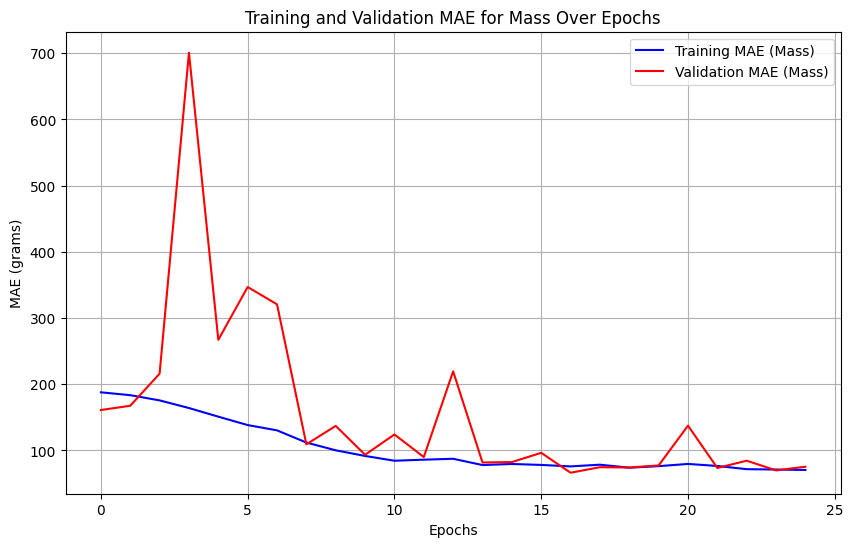

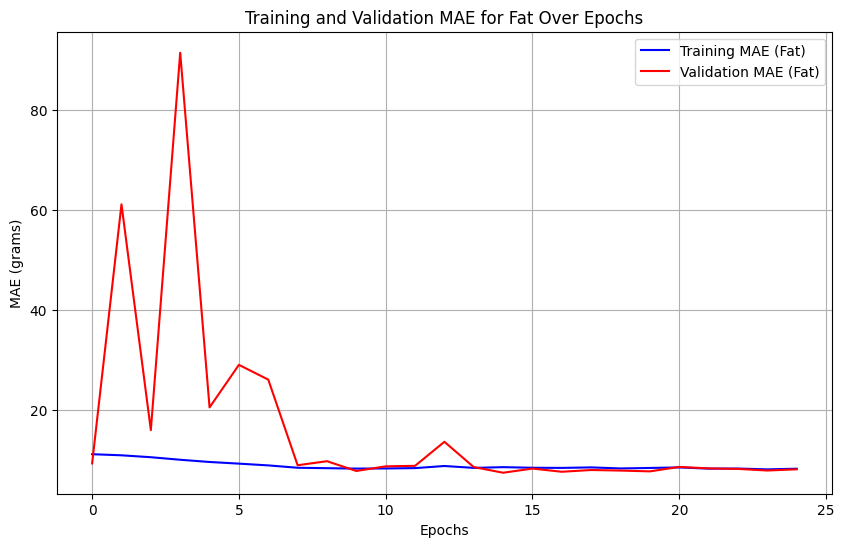

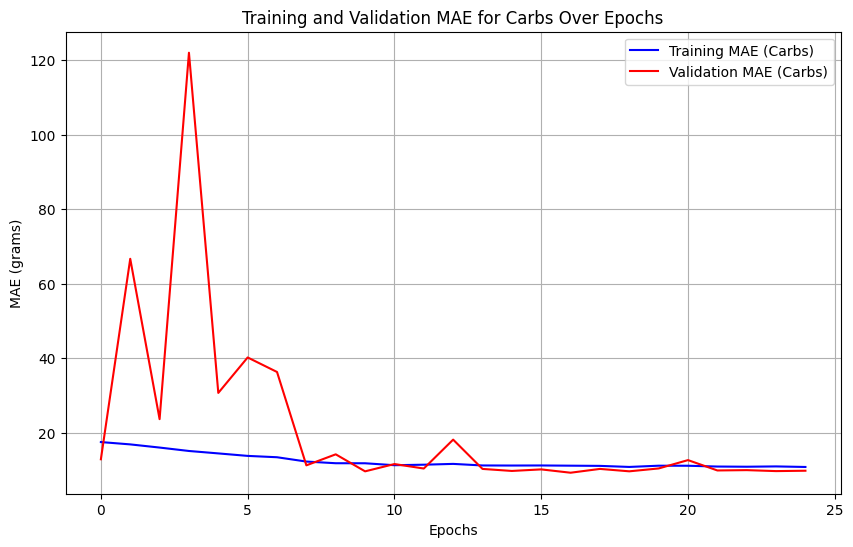

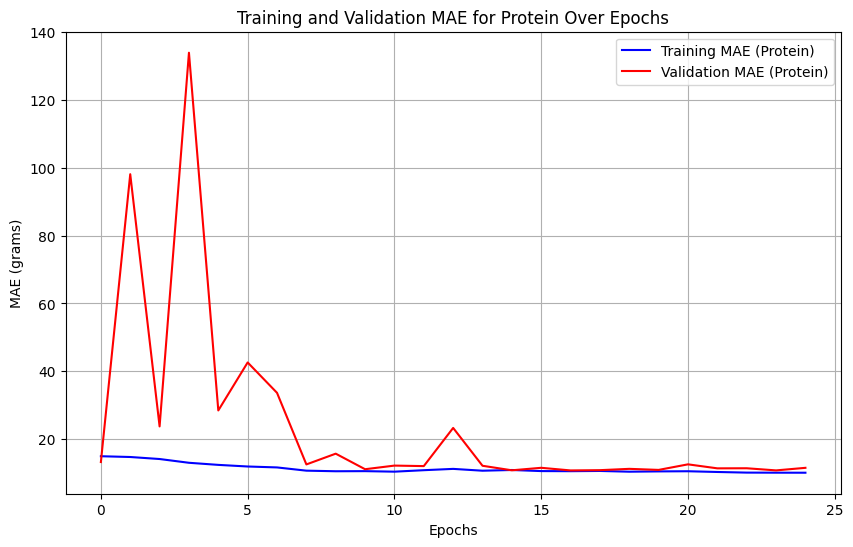

In [10]:
import matplotlib.pyplot as plt

# Extract MAE for training and validation from the history object for each output
train_mass_mae = history.history['mass_output_mae']
val_mass_mae = history.history['val_mass_output_mae']

train_fat_mae = history.history['fat_output_mae']
val_fat_mae = history.history['val_fat_output_mae']

train_carb_mae = history.history['carb_output_mae']
val_carb_mae = history.history['val_carb_output_mae']

train_protein_mae = history.history['protein_output_mae']
val_protein_mae = history.history['val_protein_output_mae']

# Plot for Mass
plt.figure(figsize=(10, 6))
plt.plot(train_mass_mae, label='Training MAE (Mass)', color='blue')
plt.plot(val_mass_mae, label='Validation MAE (Mass)', color='red')
plt.title('Training and Validation MAE for Mass Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE (grams)')
plt.legend()
plt.grid(True)
plt.show()

# Plot for Fat
plt.figure(figsize=(10, 6))
plt.plot(train_fat_mae, label='Training MAE (Fat)', color='blue')
plt.plot(val_fat_mae, label='Validation MAE (Fat)', color='red')
plt.title('Training and Validation MAE for Fat Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE (grams)')
plt.legend()
plt.grid(True)
plt.show()

# Plot for Carbs
plt.figure(figsize=(10, 6))
plt.plot(train_carb_mae, label='Training MAE (Carbs)', color='blue')
plt.plot(val_carb_mae, label='Validation MAE (Carbs)', color='red')
plt.title('Training and Validation MAE for Carbs Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE (grams)')
plt.legend()
plt.grid(True)
plt.show()

# Plot for Protein
plt.figure(figsize=(10, 6))
plt.plot(train_protein_mae, label='Training MAE (Protein)', color='blue')
plt.plot(val_protein_mae, label='Validation MAE (Protein)', color='red')
plt.title('Training and Validation MAE for Protein Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE (grams)')
plt.legend()
plt.grid(True)
plt.show()

# Prediction

In [1]:
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError


model = load_model('model/trained_model2.h5', custom_objects={'mse': MeanSquaredError()})



In [16]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load and preprocess the image 
image_path = r"C:\Users\Rafi Kyandra\VSCODE\Semester 5\Bangkit MSIB\CapstoneGithub\images\theframes\dish_1561666761\frames_sampled30\camera_A_frame_001.jpeg"
img = image.load_img(image_path, target_size=(224, 224))  # Resize the image
img_array = image.img_to_array(img)  # Convert the image to an array
img_array = img_array / 255.0  # Normalize the image to [0, 1] range
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension (1, 224, 224, 3)


In [17]:
# Make the prediction
predictions = model.predict(img_array)

# Extract predicted values for each nutrient and mass
predicted_mass = predictions[0][0]  # Mass output
predicted_fat = predictions[1][0]   # Fat output
predicted_carb = predictions[2][0]  # Carb output
predicted_protein = predictions[3][0]  # Protein output

# Display the predicted values
print(f"Predicted Mass: {predicted_mass} grams")
print(f"Predicted Fat: {predicted_fat} grams")
print(f"Predicted Carbohydrates: {predicted_carb} grams")
print(f"Predicted Protein: {predicted_protein} grams")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Predicted Mass: [162.43431] grams
Predicted Fat: [8.925454] grams
Predicted Carbohydrates: [13.874107] grams
Predicted Protein: [13.413412] grams


In [20]:
import json
from tensorflow.keras.preprocessing import image
import numpy as np

# Load and preprocess the image 
image_path = r"C:\Users\Rafi Kyandra\VSCODE\Semester 5\Bangkit MSIB\CapstoneGithub\images\theframes\dish_1561666761\frames_sampled30\camera_A_frame_001.jpeg"
img = image.load_img(image_path, target_size=(224, 224))  # Resize the image
img_array = image.img_to_array(img)  # Convert the image to an array
img_array = img_array / 255.0  # Normalize the image to [0, 1] range
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension (1, 224, 224, 3)

# Make the prediction
predictions = model.predict(img_array)

# Extract predicted values for each nutrient and mass
predicted_mass = predictions[0][0].item()  # Convert ndarray to float
predicted_fat = predictions[1][0].item()   # Convert ndarray to float
predicted_carb = predictions[2][0].item()  # Convert ndarray to float
predicted_protein = predictions[3][0].item()  # Convert ndarray to float

# Create a dictionary to hold the predictions
prediction_dict = {
    "mass": predicted_mass,
    "fat": predicted_fat,
    "carbohydrates": predicted_carb,
    "protein": predicted_protein
}

# Convert the dictionary to JSON
prediction_json = json.dumps(prediction_dict)

# Print the JSON output
print(prediction_json)

# Define the path to the JSON file
output_file = 'prediction_output.json'

# Write the predictions to the JSON file
with open(output_file, 'w') as json_file:
    json.dump(prediction_dict, json_file, indent=4)

print(f"Prediction results saved to {output_file}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
{"mass": 162.43431091308594, "fat": 8.925454139709473, "carbohydrates": 13.874107360839844, "protein": 13.413412094116211}
Prediction results saved to prediction_output.json
